Identifying Edible Mushrooms

What Characteristics Can Amateur Mushroom Foragers Use to Identify Species as Edible or Poisonous?

Presentation Slide Deck located at https://docs.google.com/presentation/d/1ZmLxz-j9GN84EmuRQPH2VdHEIdi7vNHpI8zUJ9M0DBg/edit?usp=sharing

This dataset, from Kaggle (https://www.kaggle.com/uciml/mushroom-classification?select=mushrooms.csv), contains data fo 8,124 samples of mushrooms. Amongst various features related to color, shape, smell, and texture of different parts of the mushroom anatomy is perhaps the most important feature for human purposes: Is it edible/poisonous? In this dataset, they name that feature "class."

In [ ]:
# Setting up the environment

import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pydotplus
import scipy
import seaborn as sns
sns.set_theme()
from google.colab import auth
from IPython.display import Image
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from sklearn import ensemble, datasets, linear_model, neighbors, tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sqlalchemy import create_engine

In [ ]:
# Confusion matrix function for later

def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Google SDK authorization to download csv file with from a Google Drive id

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Fetching csv file from shareable Google Drive file location

downloaded = drive.CreateFile({'id':'1bPLkxtHbXIxzlxDuVotJQczc6Dsw-45Y'})
downloaded.GetContentFile('mushrooms.csv')

In [ ]:
# Reading the dataset

df_mushrooms = pd.read_csv('mushrooms.csv')
df_mushrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

Guide to feature data:

0. class: edible=e,poisonous=p
1. cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s 
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y 
4. bruises?: bruises=t,no=f 
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s 
6. gill-attachment: attached=a,descending=d,free=f,notched=n 
7. gill-spacing: close=c,crowded=w,distant=d 
8. gill-size: broad=b,narrow=n 
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y 
10. stalk-shape: enlarging=e,tapering=t 
11. stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=? 
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s 
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s 
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
16. veil-type: partial=p,universal=u 
17. veil-color: brown=n,orange=o,white=w,yellow=y 
18. ring-number: none=n,one=o,two=t 
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z 
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y 
21. population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y 
22. habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

I'm going to clean up the column names a bit, then check for missing or null values.

In [ ]:
# Light cleaning and making new DF name so I have an original copy without reloading

df_mush = pd.DataFrame(df_mushrooms.copy())

df_mush.columns = df_mush.columns.str.strip().str.lower().str.replace('-', '_')

# Previewing column names after stripping and replacing hyphens with underscores

df_mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap_shape                 8124 non-null   object
 2   cap_surface               8124 non-null   object
 3   cap_color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill_attachment           8124 non-null   object
 7   gill_spacing              8124 non-null   object
 8   gill_size                 8124 non-null   object
 9   gill_color                8124 non-null   object
 10  stalk_shape               8124 non-null   object
 11  stalk_root                8124 non-null   object
 12  stalk_surface_above_ring  8124 non-null   object
 13  stalk_surface_below_ring  8124 non-null   object
 14  stalk_color_above_ring  

In [ ]:
# Checking for null values

df_mush.isnull().sum()*100/df_mush.count()

class                       0.0
cap_shape                   0.0
cap_surface                 0.0
cap_color                   0.0
bruises                     0.0
odor                        0.0
gill_attachment             0.0
gill_spacing                0.0
gill_size                   0.0
gill_color                  0.0
stalk_shape                 0.0
stalk_root                  0.0
stalk_surface_above_ring    0.0
stalk_surface_below_ring    0.0
stalk_color_above_ring      0.0
stalk_color_below_ring      0.0
veil_type                   0.0
veil_color                  0.0
ring_number                 0.0
ring_type                   0.0
spore_print_color           0.0
population                  0.0
habitat                     0.0
dtype: float64

In [ ]:
df_mush.head()

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
df_mush.describe()

,class,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,stalk_shape,stalk_root,stalk_surface_above_ring,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


The dataset is really clean already.

However, I do notice that "veil_type" only has 1 unique value. That won't really help or hurt me here, so I'm going to drop that feature.

In [ ]:
df_mush.drop('veil_type', axis=1, inplace=True)

Now I'm going to explore the features with only two unique values to determine whether I should explore them further or eliminate them.

In [ ]:
# Building a dataframe of features with only two unique values

df_two = pd.DataFrame()
df_two['class'] = df_mush['class']
df_two['bruises'] = df_mush['bruises']
df_two['gill_attachment'] = df_mush['gill_attachment']
df_two['gill_spacing'] = df_mush['gill_spacing']
df_two['gill_size'] = df_mush['gill_size']
df_two['stalk_shape'] = df_mush['stalk_shape']

# Converting to binary and dropping class_p (redundant)

df_twos = pd.get_dummies(df_two)
df_twos.drop(labels='class_p', axis=1, inplace=True)

# Checking for correlations

df_twos.corr()

,class_e,bruises_f,bruises_t,gill_attachment_a,gill_attachment_f,gill_spacing_c,gill_spacing_w,gill_size_b,gill_size_n,stalk_shape_e,stalk_shape_t
class_e,1.000000,-0.501530,0.501530,0.129200,-0.129200,-0.348387,0.348387,0.540024,-0.540024,-0.102019,0.102019
bruises_f,-0.501530,1.000000,-1.000000,0.137359,-0.137359,-0.299473,0.299473,-0.369596,0.369596,0.099364,-0.099364
bruises_t,0.501530,-1.000000,1.000000,-0.137359,0.137359,0.299473,-0.299473,0.369596,-0.369596,-0.099364,0.099364
gill_attachment_a,0.129200,0.137359,-0.137359,1.000000,-1.000000,0.071489,-0.071489,0.108984,-0.108984,0.186485,-0.186485
gill_attachment_f,-0.129200,-0.137359,0.137359,-1.000000,1.000000,-0.071489,0.071489,-0.108984,0.108984,-0.186485,0.186485
gill_spacing_c,-0.348387,-0.299473,0.299473,0.071489,-0.071489,1.000000,-1.000000,-0.108333,0.108333,0.080895,-0.080895
gill_spacing_w,0.348387,0.299473,-0.299473,-0.071489,0.071489,-1.000000,1.000000,0.108333,-0.108333,-0.080895,0.080895
gill_size_b,0.540024,-0.369596,0.369596,0.108984,-0.108984,-0.108333,0.108333,1.000000,-1.000000,0.214576,-0.214576
gill_size_n,-0.540024,0.369596,-0.369596,-0.108984,0.108984,0.108333,-0.108333,-1.000000,1.000000,-0.214576,0.214576
stalk_shape_e,-0.102019,0.099364,-0.099364,0.186485,-0.186485,0.080895,-0.080895,0.214576,-0.214576,1.000000,-1.000000


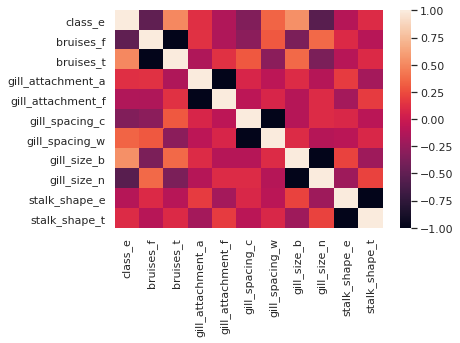

In [ ]:
ax = sns.heatmap(df_twos.corr())

I see that "bruises" and "gill_size" have over .5 and "gill_spacing" has .348; the rest is unremarkable.

Now, I'm going to explore the rest of the variables in groups to avoid having a large database that doesn't preview well on-screen.

In [ ]:
# Building a dataframe of cap features

df_cap = pd.DataFrame()
df_cap['class'] = df_mush['class']
df_cap['cap_shape'] = df_mush['cap_shape']
df_cap['cap_surface'] = df_mush['cap_surface']
df_cap['cap_color'] = df_mush['cap_color']

# Converting to binary and dropping class_p (redundant)

df_caps = pd.get_dummies(df_cap)
df_caps.drop(labels='class_p', axis=1, inplace=True)

# Checking for correlations

df_caps.corr()

,class_e,cap_shape_b,cap_shape_c,cap_shape_f,cap_shape_k,cap_shape_s,cap_shape_x,cap_surface_f,cap_surface_g,cap_surface_s,cap_surface_y,cap_color_b,cap_color_c,cap_color_e,cap_color_g,cap_color_n,cap_color_p,cap_color_r,cap_color_u,cap_color_w,cap_color_y
class_e,1.000000,0.182567,-0.023007,-0.018526,-0.163565,0.060664,0.026886,0.195415,-0.023007,-0.095454,-0.088677,-0.067544,0.030910,-0.097112,0.046456,0.044360,-0.034702,0.042854,0.042854,0.133683,-0.113014
cap_shape_b,0.182567,1.000000,-0.005387,-0.193260,-0.081769,-0.015264,-0.219564,-0.091638,0.018820,0.117712,-0.027947,0.010011,-0.017912,-0.115505,-0.069760,-0.084902,0.016231,-0.010782,-0.010782,0.212380,0.117981
cap_shape_c,-0.023007,-0.005387,1.000000,-0.017672,-0.007477,-0.001396,-0.020077,-0.014032,0.249631,-0.015038,0.015893,-0.003225,-0.001638,-0.010562,-0.012010,-0.013880,-0.002981,-0.000986,-0.000986,0.024711,0.024136
cap_shape_f,-0.018526,-0.193260,-0.017672,1.000000,-0.268226,-0.050070,-0.720235,0.064801,-0.006285,-0.093397,0.029076,0.019203,-0.003687,0.009128,0.056794,0.019014,-0.045696,0.010211,0.010211,-0.088841,-0.010390
cap_shape_k,-0.163565,-0.081769,-0.007477,-0.268226,1.000000,-0.021185,-0.304733,-0.158942,0.010863,0.137988,0.015261,-0.003209,0.041662,0.162657,-0.135632,0.125992,0.004081,-0.014965,-0.014965,-0.068190,-0.124132
cap_shape_s,0.060664,-0.015264,-0.001396,-0.050070,-0.021185,1.000000,-0.056884,0.099464,-0.001396,-0.042607,-0.051272,-0.009138,-0.004641,-0.029925,0.041093,0.030614,-0.008447,-0.002794,-0.002794,-0.024095,-0.024518
cap_shape_x,0.026886,-0.219564,-0.020077,-0.720235,-0.304733,-0.056884,1.000000,0.063511,-0.020077,-0.040634,-0.019137,-0.020175,-0.012814,-0.050400,0.054357,-0.059361,0.035996,0.004462,0.004462,0.032565,0.033317
cap_surface_f,0.195415,-0.091638,-0.014032,0.064801,-0.158942,0.099464,0.063511,1.000000,-0.014032,-0.428362,-0.515479,-0.091873,-0.002099,-0.098583,0.238650,-0.101991,-0.018841,-0.028086,-0.028086,-0.033439,0.040152
cap_surface_g,-0.023007,0.018820,0.249631,-0.006285,0.010863,-0.001396,-0.020077,-0.014032,1.000000,-0.015038,-0.018096,-0.003225,-0.001638,-0.010562,-0.012010,-0.013880,-0.002981,-0.000986,-0.000986,0.057926,-0.008654
cap_surface_s,-0.095454,0.117712,-0.015038,-0.093397,0.137988,-0.042607,-0.040634,-0.428362,-0.015038,1.000000,-0.552410,0.147418,-0.035551,-0.010886,-0.156367,0.078658,0.053626,-0.030098,-0.030098,0.181520,-0.145113


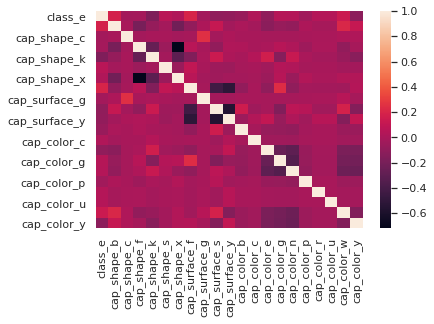

In [ ]:
ax = sns.heatmap(df_caps.corr())

Not a lot going on with cap features in relation to "class_e".

In [ ]:
# Building a dataframe of odor features

df_odor = pd.DataFrame()
df_odor['class'] = df_mush['class']
df_odor['odor'] = df_mush['odor']

# Converting to binary and dropping class_p (redundant)

df_odors = pd.get_dummies(df_odor)
df_odors.drop(labels='class_p', axis=1, inplace=True)

# Checking for correlations

df_odors.corr()

,class_e,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y
class_e,1.000000,0.219529,-0.161278,-0.623842,0.219529,-0.069159,0.785557,-0.186984,-0.286360,-0.286360
odor_a,0.219529,1.000000,-0.035405,-0.136952,-0.051787,-0.015182,-0.199381,-0.041048,-0.062864,-0.062864
odor_c,-0.161278,-0.035405,1.000000,-0.093630,-0.035405,-0.010380,-0.136312,-0.028064,-0.042979,-0.042979
odor_f,-0.623842,-0.136952,-0.093630,1.000000,-0.136952,-0.040150,-0.527269,-0.108554,-0.166247,-0.166247
odor_l,0.219529,-0.051787,-0.035405,-0.136952,1.000000,-0.015182,-0.199381,-0.041048,-0.062864,-0.062864
odor_m,-0.069159,-0.015182,-0.010380,-0.040150,-0.015182,1.000000,-0.058453,-0.012034,-0.018430,-0.018430
odor_n,0.785557,-0.199381,-0.136312,-0.527269,-0.199381,-0.058453,1.000000,-0.158038,-0.242030,-0.242030
odor_p,-0.186984,-0.041048,-0.028064,-0.108554,-0.041048,-0.012034,-0.158038,1.000000,-0.049829,-0.049829
odor_s,-0.286360,-0.062864,-0.042979,-0.166247,-0.062864,-0.018430,-0.242030,-0.049829,1.000000,-0.076312
odor_y,-0.286360,-0.062864,-0.042979,-0.166247,-0.062864,-0.018430,-0.242030,-0.049829,-0.076312,1.000000


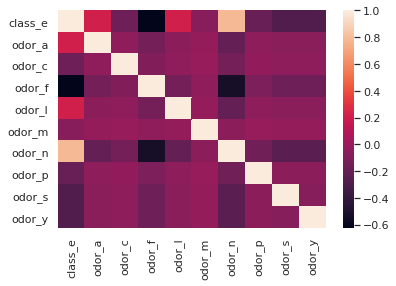

In [ ]:
ax = sns.heatmap(df_odors.corr())

I see that "odor_n" and "odor_f" have 0.786 and -0.624 respectively.

In [ ]:
# Building a dataframe of stalk features minus stalk_shape (in df_twos)

df_stalk = pd.DataFrame()
df_stalk['class'] = df_mush['class']
df_stalk['stalk_root'] = df_mush['stalk_root']
df_stalk['stalk_surface_above_ring'] = df_mush['stalk_surface_above_ring']
df_stalk['stalk_surface_below_ring'] = df_mush['stalk_surface_below_ring']
df_stalk['stalk_color_above_ring'] = df_mush['stalk_color_above_ring']
df_stalk['stalk_color_below_ring'] = df_mush['stalk_color_below_ring']

# Converting to binary and dropping class_p (redundant)

df_stalks = pd.get_dummies(df_stalk)
df_stalks.drop(labels='class_p', axis=1, inplace=True)

# Checking for correlations

df_stalks.corr()

,class_e,stalk_root_?,stalk_root_b,stalk_root_c,stalk_root_e,stalk_root_r,stalk_surface_above_ring_f,stalk_surface_above_ring_k,stalk_surface_above_ring_s,stalk_surface_above_ring_y,stalk_surface_below_ring_f,stalk_surface_below_ring_k,stalk_surface_below_ring_s,stalk_surface_below_ring_y,stalk_color_above_ring_b,stalk_color_above_ring_c,stalk_color_above_ring_e,stalk_color_above_ring_g,stalk_color_above_ring_n,stalk_color_above_ring_o,stalk_color_above_ring_p,stalk_color_above_ring_w,stalk_color_above_ring_y,stalk_color_below_ring_b,stalk_color_below_ring_c,stalk_color_below_ring_e,stalk_color_below_ring_g,stalk_color_below_ring_n,stalk_color_below_ring_o,stalk_color_below_ring_p,stalk_color_below_ring_w,stalk_color_below_ring_y
class_e,1.000000,-0.302001,-0.017712,0.218548,0.202839,0.150087,0.119503,-0.587658,0.491314,0.016198,0.136782,-0.573524,0.425444,0.081674,-0.245662,-0.069159,0.105491,0.266489,-0.233164,0.150087,-0.230277,0.217740,-0.032545,-0.245662,-0.069159,0.105491,0.266489,-0.203966,0.150087,-0.230277,0.214112,-0.056426
stalk_root_?,-0.302001,1.000000,-0.617737,-0.179671,-0.265075,-0.103132,-0.178977,0.185711,-0.077863,-0.036082,-0.138134,0.180662,-0.062844,-0.079596,-0.157092,-0.044225,0.164968,-0.183117,-0.160141,0.234707,0.185682,-0.018651,-0.020812,-0.157092,-0.044225,0.164968,-0.183117,-0.154318,0.234707,0.185682,-0.022682,0.042717
stalk_root_b,-0.017712,-0.617737,1.000000,-0.252591,-0.372655,-0.144987,-0.086857,0.105035,-0.056348,0.022032,-0.104629,0.123254,0.000894,-0.155868,0.254303,-0.062173,-0.101907,0.296431,0.259239,-0.144987,0.080820,-0.378394,-0.029258,0.254303,-0.062173,-0.101907,0.296431,0.262051,-0.144987,0.080820,-0.383081,-0.050726
stalk_root_c,0.218548,-0.179671,-0.252591,1.000000,-0.108388,-0.042170,-0.073183,-0.135459,0.159946,0.057105,-0.076542,-0.170540,0.173902,0.065194,-0.064235,0.246141,-0.029640,-0.074876,-0.065481,-0.042170,-0.148317,0.202317,0.115832,-0.064235,0.246141,-0.029640,-0.074876,-0.070296,-0.042170,-0.148317,0.207315,0.057105
stalk_root_e,0.202839,-0.265075,-0.372655,-0.108388,1.000000,-0.062215,0.436840,-0.256793,0.016648,-0.021767,0.411302,-0.251603,0.040588,-0.076109,-0.094767,-0.026679,-0.043729,-0.110467,-0.096607,-0.062215,-0.218816,0.362088,-0.012555,-0.094767,-0.026679,-0.043729,-0.110467,-0.103710,-0.062215,-0.218816,0.369349,-0.021767
stalk_root_r,0.150087,-0.103132,-0.144987,-0.042170,-0.062215,1.000000,-0.042007,-0.099910,0.117416,-0.008469,-0.043935,-0.097890,-0.193592,0.817444,-0.036871,-0.010380,-0.017013,-0.042979,-0.037586,-0.024206,-0.085134,0.140876,-0.004885,-0.036871,-0.010380,-0.017013,-0.042979,-0.040350,-0.024206,-0.085134,0.143701,-0.008469
stalk_surface_above_ring_f,0.119503,-0.178977,-0.086857,-0.073183,0.436840,-0.042007,1.000000,-0.173385,-0.357765,-0.014697,0.439938,-0.169881,-0.059488,-0.051388,-0.063986,-0.018013,-0.029525,-0.074586,-0.065228,-0.042007,-0.147743,0.244480,-0.008477,-0.063986,-0.018013,-0.029525,-0.074586,-0.021716,-0.042007,-0.147743,0.225829,-0.014697
stalk_surface_above_ring_k,-0.587658,0.185711,0.105035,-0.135459,-0.256793,-0.099910,-0.173385,1.000000,-0.850905,-0.034955,-0.181342,0.677074,-0.519615,-0.021993,0.369041,0.103892,-0.070223,-0.177396,0.357228,-0.099910,0.204071,-0.378372,-0.020161,0.369041,0.103892,-0.070223,-0.177396,0.332565,-0.099910,0.204071,-0.382397,0.044858
stalk_surface_above_ring_s,0.491314,-0.077863,-0.056348,0.159946,0.016648,0.117416,-0.357765,-0.850905,1.000000,-0.072127,-0.057041,-0.547462,0.530126,0.015410,-0.314019,-0.088402,0.082527,0.208479,-0.320114,0.117416,-0.112281,0.236618,-0.041601,-0.314019,-0.088402,0.082527,0.208479,-0.318369,0.117416,-0.112281,0.250052,-0.072127
stalk_surface_above_ring_y,0.016198,-0.036082,0.022032,0.057105,-0.021767,-0.008469,-0.014697,-0.034955,-0.072127,1.000000,-0.015371,-0.034249,-0.067732,0.285997,-0.012900,-0.003632,-0.005952,-0.015037,0.145827,-0.008469,-0.029786,-0.060115,0.576781,-0.012900,-0.003632,-0.005952,-0.015037,0.135216,-0.008469,-0.029786,-0.05893

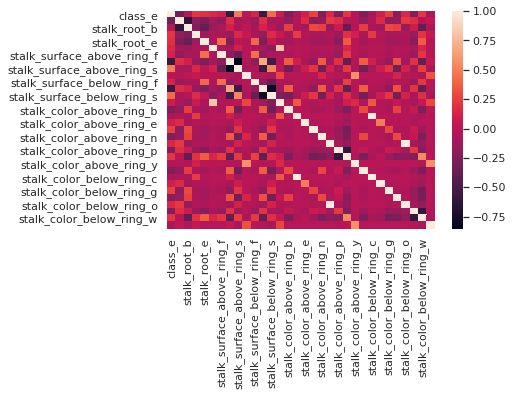

In [ ]:
ax = sns.heatmap(df_stalks.corr())

I see that "stalk_surface_above_ring_k" is -0.558;

"stalk_surface_below_ring_k" is -0.574;

"stalk_surface_above_ring_s" is 0.491;

"stalk_surface_below_ring_s" is 0.425

In [ ]:
# Building a dataframe of veil, ring, and spore print features

df_gvrsp = pd.DataFrame()
df_gvrsp['class'] = df_mush['class']
df_gvrsp['gill_color'] = df_mush['gill_color']
df_gvrsp['veil_color'] = df_mush['veil_color']
df_gvrsp['ring_number'] = df_mush['ring_number']
df_gvrsp['ring_type'] = df_mush['ring_type']
df_gvrsp['spore_print_color'] = df_mush['spore_print_color']

# Converting to binary and dropping class_p (redundant)

df_gvrsps = pd.get_dummies(df_gvrsp)
df_gvrsps.drop(labels='class_p', axis=1, inplace=True)

# Checking for correlations

df_gvrsps.corr()

,class_e,gill_color_b,gill_color_e,gill_color_g,gill_color_h,gill_color_k,gill_color_n,gill_color_o,gill_color_p,gill_color_r,gill_color_u,gill_color_w,gill_color_y,veil_color_n,veil_color_o,veil_color_w,veil_color_y,ring_number_n,ring_number_o,ring_number_t,ring_type_e,ring_type_f,ring_type_l,ring_type_n,ring_type_p,spore_print_color_b,spore_print_color_h,spore_print_color_k,spore_print_color_n,spore_print_color_o,spore_print_color_r,spore_print_color_u,spore_print_color_w,spore_print_color_y
class_e,1.000000,-0.538808,0.105491,-0.120285,-0.150694,0.149641,0.288943,0.085962,0.050380,-0.056426,0.195359,0.231316,0.046828,0.105491,0.105491,-0.140541,-0.032545,-0.069159,-0.182101,0.204600,-0.223286,0.074371,-0.451619,-0.069159,0.540469,0.074371,-0.490229,0.396832,0.416645,0.074371,-0.098024,0.074371,-0.357384,0.074371
gill_color_b,-0.538808,1.000000,-0.056839,-0.166010,-0.163566,-0.119523,-0.200034,-0.046317,-0.246536,-0.028293,-0.131972,-0.216598,-0.053764,-0.056839,-0.056839,0.082577,-0.016319,-0.034678,0.151483,-0.146781,0.721446,-0.040072,-0.226451,-0.034678,-0.507885,-0.040072,-0.260608,-0.284421,-0.293887,-0.040072,-0.049151,-0.040072,0.805573,-0.040072
gill_color_e,0.105491,-0.056839,1.000000,-0.034926,-0.034412,-0.025146,-0.042084,-0.009744,-0.051867,-0.005952,-0.027765,-0.045569,-0.011311,-0.011958,-0.011958,0.017373,-0.003433,-0.007296,-0.375220,0.387240,0.151781,-0.008431,-0.047642,-0.007296,-0.106851,-0.008431,-0.054828,-0.059838,-0.061829,-0.008431,-0.010341,-0.008431,0.169480,-0.008431
gill_color_g,-0.120285,-0.166010,-0.034926,1.000000,-0.100506,-0.073443,-0.122914,-0.028460,-0.151488,-0.017385,-0.081092,-0.133092,-0.033036,-0.034926,-0.034926,0.050741,-0.010027,-0.021308,-0.096650,0.104680,-0.230107,-0.024623,0.361929,-0.021308,-0.040188,-0.024623,0.297799,-0.073910,-0.081454,-0.024623,0.078556,-0.024623,-0.116578,-0.024623
gill_color_h,-0.150694,-0.163566,-0.034412,-0.100506,1.000000,-0.072362,-0.121105,-0.028041,-0.149258,-0.017129,-0.079898,-0.131133,-0.032550,-0.034412,-0.034412,0.049994,-0.009880,-0.020994,0.091711,-0.088864,-0.052687,0.043052,0.370089,-0.020994,-0.224922,-0.024260,0.421621,-0.074190,-0.081600,-0.024260,-0.029757,-0.024260,-0.203043,-0.024260
gill_color_k,0.149641,-0.119523,-0.025146,-0.073443,-0.072362,1.000000,-0.088495,-0.020491,-0.109068,-0.012517,-0.058384,-0.095823,-0.023785,-0.025146,-0.025146,0.036532,-0.007220,-0.015341,0.067016,-0.064936,0.062488,-0.017728,-0.100182,-0.015341,0.018853,-0.017728,-0.115293,0.147203,0.138340,-0.017728,-0.021744,-0.017728,-0.148370,-0.017728
gill_color_n,0.288943,-0.200034,-0.042084,-0.122914,-0.121105,-0.088495,1.000000,-0.034293,-0.182536,-0.020948,-0.097712,-0.160370,-0.039807,0.066660,0.066660,-0.090525,-0.012083,-0.025675,0.112159,-0.108677,-0.128610,-0.029669,-0.167665,-0.025675,0.252807,0.046995,-0.192956,0.204501,0.217813,0.046995,-0.036392,0.046995,-0.248313,0.046995
gill_color_o,0.085962,-0.046317,-0.009744,-0.028460,-0.028041,-0.020491,-0.034293,1.000000,-0.042265,-0.004850,-0.022625,-0.037133,-0.009217,0.402565,0.402565,-0.560893,-0.002798,-0.005945,0.025970,-0.025164,-0.064200,-0.006870,-0.038822,-0.005945,0.091196,0.283809,-0.044678,-0.048760,0.001613,0.283809,-0.008426,-0.006870,-0.057496,0.283809
gill_color_p,0.050380,-0.246536,-0.051867,-0.151488,-0.149258,-0.109068,-0.182536,-0.042265,1.000000,-0.025818,-0.120427,-0.197651,-0.049061,-0.051867,-0.051867,0.075354,-0.014891,-0.031644,0.024620,-0.017251,-0.213030,0.013210,0.168416,-0.031644,0.080936,-0.036567,0.190646,0.051486,0.049395,-0.036567,-0.044851,0.029802,-0.239047,-0.036567
gill_color_r,-0.056426,-0.028293,-0.005952,-0.017385,-0.017129,-0.012517,-0.020948,-0.004850,-0.025818,1.000000,-0.013821,-0.022683,-0.005630,-0.005952,-0.005952,0.008648,-0.001709,-0.003632,-0.186774,0.192758,-0.039217,-0.004196,-0.023715,-0.003632,0.055708,-0.004196,-0.027292,-0.029786,-0.030777,-0.004196,0.575637,-0.004196,-0.035122,-0.004196


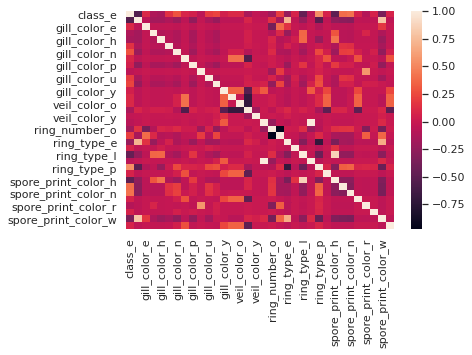

In [ ]:
ax = sns.heatmap(df_gvrsps.corr())

I see that "ring_type_p" is	0.540;

"gill_color_b" is	-0.539;

"spore_print_color_h" is	-0.490;

"ring_type_l" is	-0.452;

"spore_print_color_n" is	0.417

In [ ]:
# Building a dataframe of habitat and population features

df_pophab = pd.DataFrame()
df_pophab['class'] = df_mush['class']
df_pophab['population'] = df_mush['population']
df_pophab['habitat'] = df_mush['habitat']

# Converting to binary and dropping class_p (redundant)

df_pophabs = pd.get_dummies(df_pophab)
df_pophabs.drop(labels='class_p', axis=1, inplace=True)

# Checking for correlations

df_pophabs.corr()

,class_e,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
class_e,1.000000,0.214871,0.137645,0.219529,0.159572,-0.443722,0.107055,0.126123,0.165004,-0.155150,0.138627,-0.323346,-0.112078,0.150087
population_a,0.214871,1.000000,-0.046551,-0.050688,-0.094893,-0.221535,-0.115093,-0.177163,0.371521,-0.075237,-0.043008,-0.090174,-0.048518,-0.034654
population_c,0.137645,-0.046551,1.000000,-0.047561,-0.089038,-0.207867,-0.107992,-0.120809,-0.125300,0.156476,-0.040355,-0.084610,-0.045524,0.744425
population_n,0.219529,-0.050688,-0.047561,1.000000,-0.096950,-0.226338,-0.117588,-0.181003,0.214452,-0.076868,0.347262,-0.092129,-0.049569,-0.035405
population_s,0.159572,-0.094893,-0.089038,-0.096950,1.000000,-0.423728,-0.220138,-0.271589,0.394789,-0.143906,0.152473,-0.125366,0.130450,-0.066282
population_v,-0.443722,-0.221535,-0.207867,-0.226338,-0.423728,1.000000,-0.513929,0.171068,-0.379699,0.248675,-0.144434,0.169228,0.001180,-0.154742
population_y,0.107055,-0.115093,-0.107992,-0.117588,-0.220138,-0.513929,1.000000,0.277929,-0.129113,-0.174539,-0.099772,0.040714,-0.042888,-0.080392
habitat_d,0.126123,-0.177163,-0.120809,-0.181003,-0.271589,0.171068,0.277929,1.000000,-0.476858,-0.268668,-0.153579,-0.322005,-0.173254,-0.123748
habitat_g,0.165004,0.371521,-0.125300,0.214452,0.394789,-0.379699,-0.129113,-0.476858,1.000000,-0.202512,-0.115762,-0.242715,-0.130592,-0.093276
habitat_l,-0.155150,-0.075237,0.156476,-0.076868,-0.143906,0.248675,-0.174539,-0.268668,-0.202512,1.000000,-0.065222,-0.136749,-0.073577,-0.052553


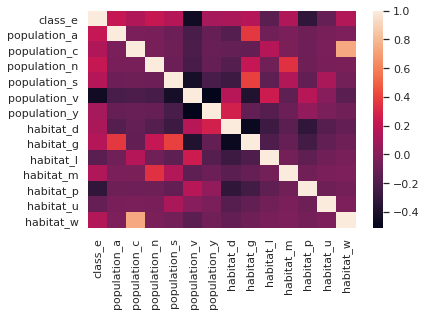

In [ ]:
ax = sns.heatmap(df_pophabs.corr())

I see that "population_v" is	-0.444

I'm going to build a new dataframe with the most correlated features from above.

In [ ]:
df_shrooms = pd.DataFrame()
df_shrooms['edible'] = df_twos['class_e'] # edible
df_shrooms['bruises'] = df_twos['bruises_t'] # bruises
df_shrooms['gill_narrow'] = df_twos['gill_size_n'] # gill size narrow
df_shrooms['odor_none'] = df_odors['odor_n'] # no odor
df_shrooms['odor_foul'] = df_odors['odor_f'] # foul odor
df_shrooms['silky_stalk_ab'] = df_stalks['stalk_surface_above_ring_k'] # silky stalk above ring
df_shrooms['silky_stalk_be'] = df_stalks['stalk_surface_below_ring_k'] # silky stalk below ring
df_shrooms['smooth_stalk_ab'] = df_stalks['stalk_surface_above_ring_s'] # smooth stalk above ring
df_shrooms['smooth_stalk_be'] = df_stalks['stalk_surface_below_ring_s'] # smooth stalk below ring
df_shrooms['ring_pend'] = df_gvrsps['ring_type_p'] # pendant ring
df_shrooms['gill_color_buff'] = df_gvrsps['gill_color_b'] # buff color
df_shrooms['spore_print_chocolate'] = df_gvrsps['spore_print_color_h'] # chocolate color
df_shrooms['ring_large'] = df_gvrsps['ring_type_l'] # large ring
df_shrooms['spore_print_brown'] = df_gvrsps['spore_print_color_n'] # brown
df_shrooms['pop_several'] = df_pophabs['population_v'] # several populations

df_shrooms.head()

,edible,bruises,gill_narrow,odor_none,odor_foul,silky_stalk_ab,silky_stalk_be,smooth_stalk_ab,smooth_stalk_be,ring_pend,gill_color_buff,spore_print_chocolate,ring_large,spore_print_brown,pop_several
0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0
1,1,1,0,0,0,0,0,1,1,1,0,0,0,1,0
2,1,1,0,0,0,0,0,1,1,1,0,0,0,1,0
3,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0
4,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0


With a dataframe of all binary features, I don't expect that boxplots or outliers really mean anything here, but let me check before I call it quits on cleaning.

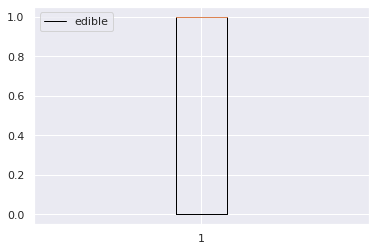

In [ ]:
plt.boxplot(df_shrooms['edible'])
plt.legend(['edible'], loc ='upper left')

Just as I suspected.

I'm finished with cleaning, so I'm going to do more exploring.

In [ ]:
df_shrooms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   edible                 8124 non-null   uint8
 1   bruises                8124 non-null   uint8
 2   gill_narrow            8124 non-null   uint8
 3   odor_none              8124 non-null   uint8
 4   odor_foul              8124 non-null   uint8
 5   silky_stalk_ab         8124 non-null   uint8
 6   silky_stalk_be         8124 non-null   uint8
 7   smooth_stalk_ab        8124 non-null   uint8
 8   smooth_stalk_be        8124 non-null   uint8
 9   ring_pend              8124 non-null   uint8
 10  gill_color_buff        8124 non-null   uint8
 11  spore_print_chocolate  8124 non-null   uint8
 12  ring_large             8124 non-null   uint8
 13  spore_print_brown      8124 non-null   uint8
 14  pop_several            8124 non-null   uint8
dtypes: uint8(15)
memory usage: 119.1 KB


In [ ]:
# Reviewing the correllations as a new set

df_shrooms.corr()

,edible,bruises,gill_narrow,odor_none,odor_foul,silky_stalk_ab,silky_stalk_be,smooth_stalk_ab,smooth_stalk_be,ring_pend,gill_color_buff,spore_print_chocolate,ring_large,spore_print_brown,pop_several
edible,1.000000,0.501530,-0.540024,0.785557,-0.623842,-0.587658,-0.573524,0.491314,0.425444,0.540469,-0.538808,-0.490229,-0.451619,0.416645,-0.443722
bruises,0.501530,1.000000,-0.369596,0.285171,-0.344642,-0.541494,-0.530549,0.561572,0.505796,0.767036,-0.438292,-0.243244,-0.367368,0.334734,-0.179268
gill_narrow,-0.540024,-0.369596,1.000000,-0.457211,-0.055394,0.095225,0.089569,-0.009116,0.005320,-0.308466,0.776903,-0.303538,-0.291479,-0.179356,0.506475
odor_none,0.785557,0.285171,-0.457211,1.000000,-0.527269,-0.466499,-0.471920,0.347192,0.370483,0.352151,-0.455399,-0.409532,-0.381707,0.283649,-0.275386
odor_foul,-0.623842,-0.344642,-0.055394,-0.527269,1.000000,0.584189,0.600449,-0.547107,-0.502339,-0.427514,0.079360,0.799752,0.723932,-0.340268,0.163744
silky_stalk_ab,-0.587658,-0.541494,0.095225,-0.466499,0.584189,1.000000,0.677074,-0.850905,-0.519615,-0.549484,0.237814,0.553735,0.678434,-0.363087,0.197322
silky_stalk_be,-0.573524,-0.530549,0.089569,-0.471920,0.600449,0.677074,1.000000,-0.547462,-0.782903,-0.536122,0.249536,0.567865,0.692430,-0.355748,0.200032
smooth_stalk_ab,0.491314,0.561572,-0.009116,0.347192,-0.547107,-0.850905,-0.547462,1.000000,0.530126,0.581730,-0.148232,-0.541685,-0.577283,0.311985,-0.089081
smooth_stalk_be,0.425444,0.505796,0.005320,0.370483,-0.502339,-0.519615,-0.782903,0.530126,1.000000,0.535132,-0.114520,-0.533276,-0.542106,0.284942,-0.039646
ring_pend,0.540469,0.767036,-0.308466,0.352151,-0.427514,-0.549484,-0.536122,0.581730,0.535132,1.000000,-0.507885,-0.312906,-0.425700,0.357942,-0.203531


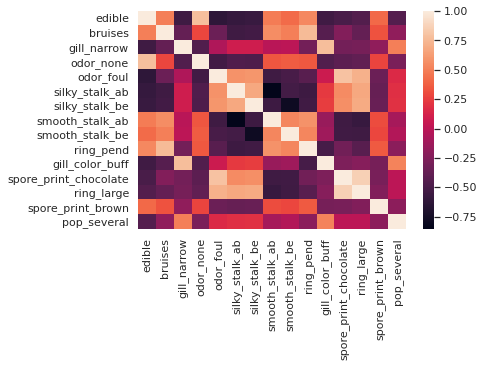

In [ ]:
ax = sns.heatmap(df_shrooms.corr())

There's a lot of moderate correllation going on here amongst features other than "edible" that I've noticed.

Now I have a dataframe with the most correllated features that I will work with from here.

First, I will do a random forest ensemble model.

In [ ]:
# Prepping for ensemble modeling
df = pd.DataFrame(df_shrooms.copy())

# Defining outcome and predictors
# Setting the outcomes to 0 and 1
y = df['edible'] - 1
df.drop('edible', axis=1, inplace=True)
X = df

# Creating training and test sets
offset = int(X.shape[0] * 0.8)

# 80% of the data in the training set
X_train, y_train = X[:offset], y[:offset]

# 20% in the test set
X_test, y_test = X[offset:], y[offset:]

Confusion matrix, without normalization


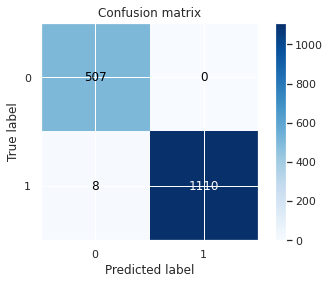

In [ ]:
# Preparing a random forest ensemble
params = {'n_estimators': 500,
          'max_depth': 2,}
 
# Initializing and fitting the model.
clf = ensemble.RandomForestClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [ ]:
clf.score(X_test, y_test)

0.9950769230769231

In [ ]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred,pos_label=0)

0.9844660194174757

In [ ]:
recall_score(y_test,y_pred,pos_label=0)

1.0

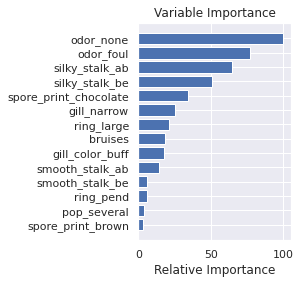

In [ ]:
feature_importance = clf.feature_importances_

# Making importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Visualizing importances
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

That was great for a first run!

I'll tune the parameters a bit.

Confusion matrix, without normalization
Accuracy: 0.9950769230769231


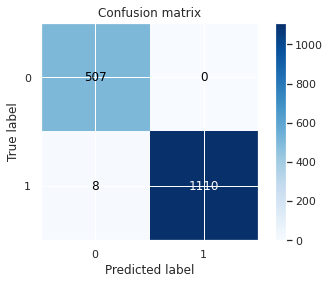

In [ ]:
# Preparing a random forest ensemble
params = {'n_estimators': 1000,
          'max_depth': 3,}

# Initializing and fitting the model.
clf = ensemble.RandomForestClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

print('Accuracy:', clf.score(X_test, y_test))

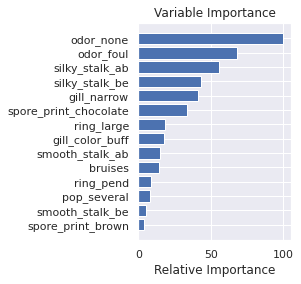

In [ ]:
feature_importance = clf.feature_importances_

# Making importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Visualizing importances
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

No change. I'll try something else.

Confusion matrix, without normalization
Accuracy: 0.9950769230769231


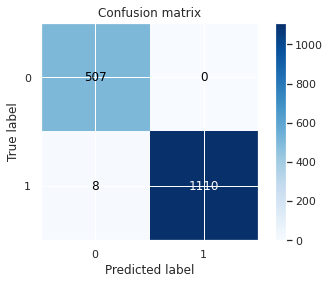

In [ ]:
# Preparing a random forest ensemble
params = {'n_estimators': 1000,
          'max_depth': 5,}

# Initializing and fitting the model.
clf = ensemble.RandomForestClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

print('Accuracy:', clf.score(X_test, y_test))

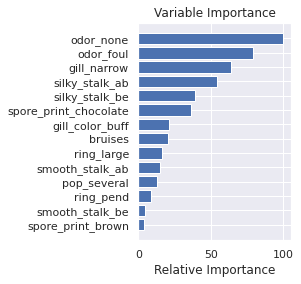

In [ ]:
feature_importance = clf.feature_importances_

# Making importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Visualizing importances
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Confusion matrix, without normalization
Accuracy: 0.9950769230769231


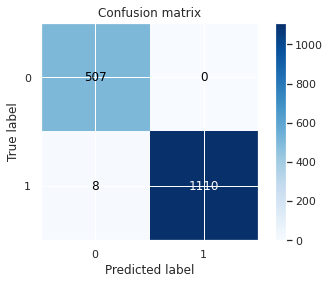

In [ ]:
# Preparing a random forest ensemble
params = {'n_estimators': 5000,
          'max_depth': None}

# Initializing and fitting the model.
clf = ensemble.RandomForestClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

print('Accuracy:', clf.score(X_test, y_test))

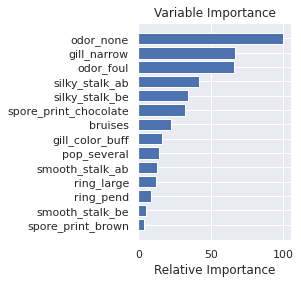

In [ ]:
feature_importance = clf.feature_importances_

# Making importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Visualizing importances
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

I don't think the random forest model is going to get much better than this.

99.5% accuracy is awesome, though!

Let's see what I can do with the gradient boosting model next.

Confusion matrix, without normalization
Accuracy: 0.9950769230769231


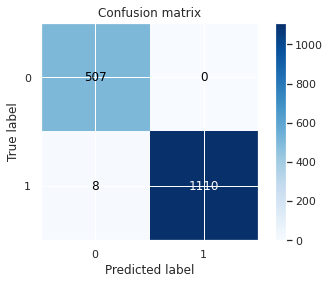

In [ ]:
# Preparing a gradient boosting ensemble
params = {'n_estimators': 1000,
          'max_depth': None}


# Initializing and fitting the model.
clf = ensemble.GradientBoostingClassifier( **params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

print('Accuracy:', clf.score(X_test, y_test))

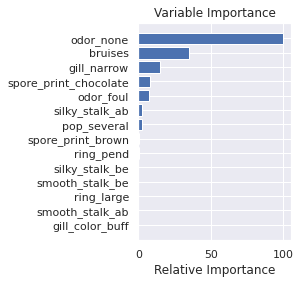

In [ ]:
feature_importance = clf.feature_importances_

# Making importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Visualizing importances
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
clf.score(X_test, y_test)

0.9950769230769231

In [ ]:
y_pred = clf.predict(X_test)
precision_score(y_test,y_pred,pos_label=0)

0.9844660194174757

In [ ]:
recall_score(y_test,y_pred,pos_label=0)

1.0

Confusion matrix, without normalization
Accuracy: 0.9950769230769231


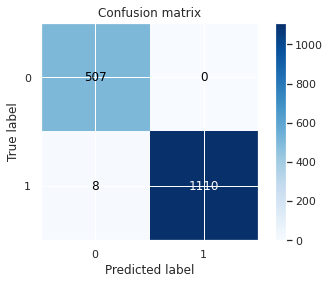

In [ ]:
# Preparing a gradient boosting ensemble
params = {'n_estimators': 5000,
          'max_depth': None,
          'learning_rate': 0.05}

# Initializing and fitting the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

print('Accuracy:', clf.score(X_test, y_test))

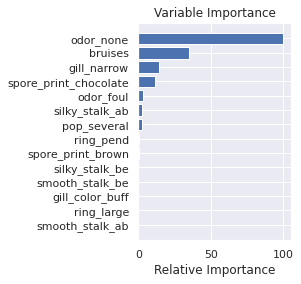

In [ ]:
feature_importance = clf.feature_importances_

# Making importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Visualizing importances
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

I'm going to try a few more things here:

In [ ]:
# Gaussian Naive Bayes algorithm for classification

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print('Number of mislabeled points out of a total %d points : %d'
      % (X_test.shape[0], (y_test != y_pred).sum()))
print('Accuracy:', (1-((y_test != y_pred).sum())/(X_test.shape[0])))

Number of mislabeled points out of a total 1625 points : 210
Accuracy: 0.8707692307692307


Not as good as the decision tree ensemble.

In [ ]:
# Trying a logistic regression classifier

clf = LogisticRegression(solver='liblinear', class_weight='balanced').fit(X, y)
clf.predict(X)

array([255,   0,   0, ...,   0, 255,   0], dtype=uint8)

In [ ]:
clf.predict_proba(X)

array([[0.21108545, 0.78891455],
       [0.94450575, 0.05549425],
       [0.94450575, 0.05549425],
       ...,
       [0.98835508, 0.01164492],
       [0.00908289, 0.99091711],
       [0.98835508, 0.01164492]])

In [ ]:
clf.score(X, y)

0.9773510585918267

The scikit-learn logistic regression classifier using the 'liblinear' solver resulted in a slightly lower 97.7%

Looks like the Decision Tree Ensemble model worked the best, coming in at over 99.5%!